# All-Sky Texture

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pathlib import Path

In [3]:
import io

In [4]:
import requests

In [5]:
import healpy

In [6]:
from scipy.interpolate import SmoothSphereBivariateSpline

In [7]:
from PIL import Image

In [8]:
def get_tanproj(ra=60, dec=30, fov=60, size=200, layer='unwise-neo6'):
    pixscale = fov * 3600 / size
    url = f'https://www.legacysurvey.org/viewer/cutout.jpg?ra={ra}&dec={dec}&layer={layer}&pixscale={pixscale}&size={size}'
    r = requests.get(url)
    return Image.open(io.BytesIO(r.content))

#img = get_tanproj()

In [9]:
def get_healpix(nside):
    """Angles returned in degrees"""
    resol = np.rad2deg(healpy.pixelfunc.nside2resol(nside=nside))
    npix = healpy.pixelfunc.nside2npix(nside)
    ipix = np.arange(npix)
    theta, ra = np.rad2deg(healpy.pix2ang(nside=nside, ipix=ipix))
    dec = 90 - theta
    ra = np.fmod(ra + 360, 360)
    #fov = np.round(1.5 * (1 + 0.7 * np.abs(dec / 90) ** 4) * resol, 3)
    #fov = np.round(1.3 * (1 + 0.6 * np.abs(dec / 90) ** 4) * resol, 3)
    fov = np.round(1.4 * (1 + 0.5 * np.abs(dec / 90) ** 4) * resol, 3)
    return ipix, ra, dec, fov

nside=4 npix=192


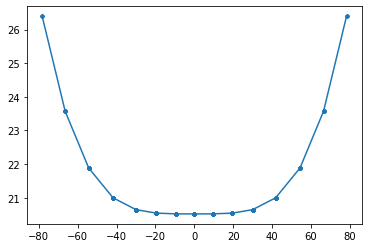

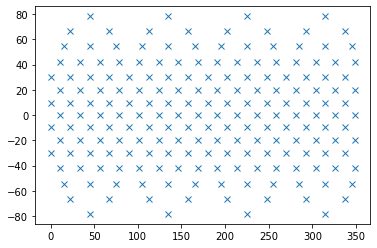

In [10]:
def plot_healpix(nside=4):
    ipix, ra, dec, fov = get_healpix(nside)
    print(f'nside={nside} npix={len(ipix)}')
    plt.plot(dec, fov, '.-')
    plt.show()
    plt.plot(ra, dec, 'x')
    plt.show()
    
plot_healpix()

In [11]:
def get_allprojs(nside=4, size=500, layer='unwise-neo6', overwrite=False):
    ipix, ra, dec, fov = get_healpix(nside)
    npix = len(ipix)
    for i in ipix:
        fname = f'{layer}/tan-{i}-{npix}-{size}.png'
        if overwrite or not Path(fname).exists():
            img = get_tanproj(ra[i], dec[i], fov[i], size=size, layer=layer)
            print(fname)
            img.save(fname)

In [48]:
get_allprojs(layer='sfd', overwrite=True)

sfd/tan-0-192-500.png
sfd/tan-1-192-500.png
sfd/tan-2-192-500.png
sfd/tan-3-192-500.png
sfd/tan-4-192-500.png
sfd/tan-5-192-500.png
sfd/tan-6-192-500.png
sfd/tan-7-192-500.png
sfd/tan-8-192-500.png
sfd/tan-9-192-500.png
sfd/tan-10-192-500.png
sfd/tan-11-192-500.png
sfd/tan-12-192-500.png
sfd/tan-13-192-500.png
sfd/tan-14-192-500.png
sfd/tan-15-192-500.png
sfd/tan-16-192-500.png
sfd/tan-17-192-500.png
sfd/tan-18-192-500.png
sfd/tan-19-192-500.png
sfd/tan-20-192-500.png
sfd/tan-21-192-500.png
sfd/tan-22-192-500.png
sfd/tan-23-192-500.png
sfd/tan-24-192-500.png
sfd/tan-25-192-500.png
sfd/tan-26-192-500.png
sfd/tan-27-192-500.png
sfd/tan-28-192-500.png
sfd/tan-29-192-500.png
sfd/tan-30-192-500.png
sfd/tan-31-192-500.png
sfd/tan-32-192-500.png
sfd/tan-33-192-500.png
sfd/tan-34-192-500.png
sfd/tan-35-192-500.png
sfd/tan-36-192-500.png
sfd/tan-37-192-500.png
sfd/tan-38-192-500.png
sfd/tan-39-192-500.png
sfd/tan-40-192-500.png
sfd/tan-41-192-500.png
sfd/tan-42-192-500.png
sfd/tan-43-192-500.pn

In [14]:
#get_allprojs(layer='unwise-neo6', overwrite=True)

In [15]:
def openingAngle(lat1, lat2, lon1, lon2):
    """Inputs and output in radians"""
    hav = lambda x: sin(x / 2) ** 2
    havl12 = hav(lat2 - lat1)
    havth = havl12 + (1 - havl12 - hav(lat1 + lat2)) * hav(lon2 - lon1)
    return 2 * np.arcsin(np.sqrt(havth))

In [16]:
def downsample(data, downsampling, summary=np.sum, allow_trim=False):
    """Downsample a 2D array.
    
    Parameters
    ----------
    data : array
        Two dimensional array of values to downsample.
    downsampling : int
        Downsampling factor to use along both dimensions. Must evenly divide the
        data dimensions when allow_trim is False.
    summary : callable
        The summary function to use that will be applied to each block of shape
        (dowsampling, downsampling) to obtain the output downsampled values.
        Must support broadcasting and an axis parameter. Useful choices are
        np.sum, np.mean, np.min, np.max, np.median, np.var but any ufunc
        should work.
    allow_trim : bool
        When False, the input dimensions (ny, nx) must both exactly divide
        the downsampling value.  Otherwise, any extra rows and columns are
        silently trimmed before apply the summary function.

    Returns
    -------
    array
        A two dimensional array of shape (ny // downsampling, nx // downsampling)
        where the input data shape is (ny, nx).
    """
    data = np.asarray(data)
    if data.ndim != 2:
        raise ValueError('Data must be 2 dimensional.')
    ny, nx = data.shape
    if not allow_trim and ((nx % downsampling) or (ny % downsampling)):
        raise ValueError('Data shape {0} does not evenly divide downsampling={1} and allow_trim is False.'
                         .format((ny, nx), downsampling))
    ny //= downsampling
    nx //= downsampling
    shape = (ny, nx, downsampling, downsampling)
    strides = (downsampling * data.strides[0], downsampling * data.strides[1]) + data.strides
    blocks = np.lib.stride_tricks.as_strided(
        data[:downsampling * ny, :downsampling * nx], shape=shape, strides=strides)
    return summary(blocks, axis=(2, 3))

In [46]:
def project(nside=4, tansize=500, fullsize=4000, oversampling=1, layer='unwise-neo6'):
    """
    """
    ipix, rapix, decpix, fov = get_healpix(nside)
    npix = len(ipix)
    rapix = np.deg2rad(rapix)
    decpix = np.deg2rad(decpix)

    fullsize *= oversampling
    output = np.zeros((fullsize, 2 * fullsize, 3), np.float32)
    osum = np.zeros((fullsize, 2 * fullsize), np.float32)
    print(f'Buffer memory usage: {(output.nbytes + osum.nbytes) / (1<<20):.3f}Mb')

    thetagrid = np.linspace(0, np.pi, fullsize, endpoint=True)
    phigrid = np.linspace(0, 2 * np.pi, 2 * fullsize, endpoint=False)

    for i in ipix:
        print(f'projecting healpix {i+1} of {npix}...')
        ra0, dec0 = rapix[i], decpix[i]
        fname = f'{layer}/tan-{i}-{npix}-{tansize}.png'
        img = np.array(Image.open(fname))
        assert img.shape == (tansize, tansize, 3)
        # Calculate unit vectors at center of each pixel for TAN projection at north pole.
        pixscale = fov[i] * 3600 / tansize # arcsec / pixel
        pix = np.arange(tansize)
        xy = (pix - (tansize - 1) / 2) * np.deg2rad(pixscale / 3600)
        x, y = np.meshgrid(xy, xy)
        ypix, xpix = np.meshgrid(pix, pix)
        r = np.sqrt(1 + x ** 2 + y ** 2)
        x /= r
        y /= r
        z = 1 / r
        xyz = np.stack((x,y,z)).reshape(3, -1)
        # Convert unit vectors to (ra,dec) for TAN projection centered at (ra0,dec0).
        cosdec0 = np.cos(dec0)
        sindec0 = np.sin(dec0)
        cosra0 = np.cos(ra0)
        sinra0 = np.sin(ra0)
        rot = np.array([
            [sindec0 * cosra0, -sinra0, cosdec0 * cosra0],
            [sindec0 * sinra0, cosra0, cosdec0 * sinra0],
            [-cosdec0, 0, sindec0]])
        xr,yr,zr = rot.dot(xyz)
        dec = np.rad2deg(np.arcsin(zr))
        ra = np.fmod(np.rad2deg(np.arctan2(yr, xr)) + 360, 360)

        theta = np.deg2rad(90 - dec)
        assert np.all((theta >= 0) & (theta <= np.pi))
        phi = np.deg2rad(ra)
        assert np.all((phi >= 0) & (phi <= 2 * np.pi))
        
        wgts = None #np.full_like(theta, 0.05)
        xpixf = SmoothSphereBivariateSpline(theta, phi, xpix.reshape(-1), w=wgts, s=None)
        ypixf = SmoothSphereBivariateSpline(theta, phi, ypix.reshape(-1), w=wgts, s=None)

        angle = openingAngle(np.pi/2 - thetagrid.reshape(-1, 1), dec0, phigrid, ra0)
        xgrid = np.round(xpixf(thetagrid, phigrid, grid=True))
        ygrid = np.round(ypixf(thetagrid, phigrid, grid=True))
        inside = (xgrid >= 0) & (xgrid < tansize) & (ygrid >= 0) & (ygrid < tansize) & (angle < np.deg2rad(0.75 * fov[i]))
        xgrid[~inside] = np.nan
        ygrid[~inside] = np.nan

        iy, ix = np.where(inside)
        jy = ygrid[iy, ix].astype(int)
        jx = xgrid[iy, ix].astype(int)
        output[iy, ix] += img[jy, tansize-1-jx]
        osum[iy, ix] += 1

    #fig = plt.figure(figsize=(12, 6))
    #plt.imshow(osum, interpolation='none', extent=(0, 2 * np.pi, np.pi, 0), origin='upper')
    #plt.show()

    osum *= 255
    osum = osum.reshape(osum.shape + (1,))
    output = np.divide(output, osum, where=osum > 0, out=output)
    #np.save(f'{layer}.npy', output)

    downsampled = np.stack([downsample(output[:,:,k], oversampling, np.mean) for k in range(3)], axis=2)
    
    img = Image.fromarray(np.uint8(downsampled / downsampled.max() * 255))
    img.save(f'{layer}.jpg', quality=95)

    #fig = plt.figure(figsize=(12, 6))
    #plt.imshow(output, interpolation='none', extent=(0, 2 * np.pi, np.pi, 0), origin='upper')

    return img

In [41]:
output = np.load('unwise-neo6.npy')

In [42]:
downsampled = np.stack([downsample(output[:,:,k], 1, np.mean) for k in range(3)], axis=2)

In [43]:
img = Image.fromarray(np.uint8(downsampled / downsampled.max() * 255))
#img = Image.fromarray(np.uint8(downsampled * 255))
img.save('unwise-neo6.jpg', quality=95)

In [29]:
output.shape, downsampled.shape

((4000, 8000, 3), (4000, 8000, 3))

In [47]:
%time img = project(layer='unwise-neo6', oversampling=2)

Buffer memory usage: 1953.125Mb
projecting healpix 1 of 192...
projecting healpix 2 of 192...
projecting healpix 3 of 192...
projecting healpix 4 of 192...
projecting healpix 5 of 192...
projecting healpix 6 of 192...
projecting healpix 7 of 192...
projecting healpix 8 of 192...
projecting healpix 9 of 192...
projecting healpix 10 of 192...
projecting healpix 11 of 192...
projecting healpix 12 of 192...
projecting healpix 13 of 192...
projecting healpix 14 of 192...
projecting healpix 15 of 192...
projecting healpix 16 of 192...
projecting healpix 17 of 192...
projecting healpix 18 of 192...
projecting healpix 19 of 192...
projecting healpix 20 of 192...
projecting healpix 21 of 192...
projecting healpix 22 of 192...
projecting healpix 23 of 192...
projecting healpix 24 of 192...
projecting healpix 25 of 192...
projecting healpix 26 of 192...
projecting healpix 27 of 192...
projecting healpix 28 of 192...
projecting healpix 29 of 192...
projecting healpix 30 of 192...
projecting healpi

In [57]:
output.shape

(4000, 8000, 3)

In [162]:
img = Image.fromarray(np.uint8(output / output.max() * 255))

In [163]:
img.save('galex-32M.png')

In [164]:
img.save('galex-32M.jpg', quality=95)#, subsampling=0)

In [49]:
img2 = project(layer='sfd', oversampling=2)

Buffer memory usage: 1953.125Mb
projecting healpix 1 of 192...
projecting healpix 2 of 192...
projecting healpix 3 of 192...
projecting healpix 4 of 192...
projecting healpix 5 of 192...
projecting healpix 6 of 192...
projecting healpix 7 of 192...
projecting healpix 8 of 192...
projecting healpix 9 of 192...
projecting healpix 10 of 192...
projecting healpix 11 of 192...
projecting healpix 12 of 192...
projecting healpix 13 of 192...
projecting healpix 14 of 192...
projecting healpix 15 of 192...
projecting healpix 16 of 192...
projecting healpix 17 of 192...
projecting healpix 18 of 192...
projecting healpix 19 of 192...
projecting healpix 20 of 192...
projecting healpix 21 of 192...
projecting healpix 22 of 192...
projecting healpix 23 of 192...
projecting healpix 24 of 192...
projecting healpix 25 of 192...
projecting healpix 26 of 192...
projecting healpix 27 of 192...
projecting healpix 28 of 192...
projecting healpix 29 of 192...
projecting healpix 30 of 192...
projecting healpi